#**IMPORT LIBRARY**

In [8]:
# dataset
!pip install ucimlrepo

# debug
!pip install ipdb

# data profiling
!pip install ydata_profiling

# visualize
!pip install colorama

# Elbow method for k-Means
!pip install yellowbrick
# K-distance for DBSCAN
!pip install kneebow

In [109]:
# dataset
from ucimlrepo import fetch_ucirepo

# debug
import ipdb
%pdb on

import numpy as np
import pandas as pd
# Visualize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored
from termcolor import cprint
# Figure&Display options
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import datetime
import datetime as dt
from datetime import datetime, timedelta

# Scaling
from sklearn.preprocessing import PowerTransformer

# Modelling
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
  # NearestNeighbors to find eps for DBSCAN and visualize the elbow method
from sklearn.neighbors import NearestNeighbors
from kneebow.rotor import Rotor
  # Elbow method for k-Means
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

# Evaluate the perfomance of ModelS
from sklearn.metrics import silhouette_score

# data profiling
!pip install ydata_profiling
import ydata_profiling
from ydata_profiling.report.presentation.flavours.html.templates import create_html_assets

Automatic pdb calling has been turned ON


#**DATASET**

In [94]:
# fetch dataset
online_retail = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = online_retail.data.features
y = online_retail.data.targets

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [95]:
# display data
path = online_retail.metadata['data_url']
df0 = pd.read_csv(path, encoding='latin1')
df = df0.copy()
display(df.head())

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55    17850.00  United Kingdom  
1  12/1/2010 8:26       3.39    17850.00  United Kingdom  
2  12/1/2010 8:26       2.75    17850.00  United Kingdom  
3  12/1/2010 8:26       3.39    17850.00  United Kingdom  
4  12/1/2010 8:26       3.39    17850.00  United Kingdom

In [96]:
# Observate raw data
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#**Remove the missing, dupplicate and specific values**

In [97]:
def missing_columns_and_numbers(df):
  missing_number = df.isnull().sum().sort_values(ascending=False)
  missing_cols = df.columns[df.isna().any()].tolist()
  missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
  return missing_cols, missing_values[missing_values['Missing_Number']>0]

def drop_null_rows(df, missing_cols = []):
  if missing_cols != []:
    for col in missing_cols:
      temp_indxs = df[df[col].isnull()].index.tolist()
      df.drop(temp_indxs, axis=0, inplace=True)

def remove_rows_conditions(df,col_name, condition, value):
  if condition == '<':
    temp_indxs = df[df[col_name]<value].index.tolist()
  elif condition == '>':
    temp_indxs = df[df[col_name]>value].index.tolist()
  elif condition == '==':
    temp_indxs = df[df[col_name]==value].index.tolist()
  elif condition == '!=':
    temp_indxs = df[df[col_name]!=value].index.tolist()

  df.drop(temp_indxs, axis=0, inplace=True)


def duplicate_values(df):
  print('\n\n')
  print(colored("Duplicate check...", attrs=['bold']), sep='')
  duplicate_values = df.duplicated(subset=None, keep='first').sum()
  if duplicate_values > 0:
      df.drop_duplicates(keep='first', inplace=True)
      print(duplicate_values, colored(" Duplicates were dropped!"),'\n',
            colored('*'*100, 'red', attrs=['bold']), sep='')
  else:
      print(colored("There are no duplicates"),'\n',
            colored('*'*100, 'red', attrs=['bold']), sep='')
#-------------------------------------------------------------------------------
df = df0.copy()

# Detect the columns that missing values and the number of values that missing
missing_cols, missing_values  = missing_columns_and_numbers(df)
print('\nMissing Values Sumary:\n',missing_values)

# Remove missing values based on rows
drop_null_rows(df, missing_cols)
new_missing_cols, new_missing_values  = missing_columns_and_numbers(df)
print('\n\nAfter drop null rows')
print('\nMissing Values Sumary:\n',new_missing_values)

# Remove duplicated
duplicate_values(df)


Missing Values Sumary:
              Missing_Number  Missing_Percent
CustomerID           135080             0.25
Description            1454             0.00


After drop null rows

Missing Values Sumary:
 Empty DataFrame
Columns: [Missing_Number, Missing_Percent]
Index: []



Duplicate check...
5225 Duplicates were dropped!
****************************************************************************************************


In [98]:
# Check the information the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


In [99]:
df1 = df.copy()
# REMOVE CANCELING THE SERVICE = REMOVE Quantity <0
remove_rows_conditions(df1,'Quantity', '<', 0)
# REMOVE SAMPLES HAVE UnitPrece == 0
remove_rows_conditions(df1,'UnitPrice', '==', 0)
# KEEP SAMPLES THAT LOCATED IN UNITED KINGDOM
remove_rows_conditions(df1,'Country', '!=', 'United Kingdom')

In [100]:
# Recheck the dataset after process
df1.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#**EXTRACT THE RECENCY, FREQUENCY, MONETARY FEATURES**

In [101]:
df2 = df1.copy()
df2.drop(['StockCode', 'Description', 'Country'],axis = 1,inplace=True)
df2['total_price'] = df2['Quantity'] * df2['UnitPrice']

In [102]:
# change InvoiceDate column type string into datetime
df3 = df2.copy()
#date_format = '%m/%d/%Y %I:%M'
date_format = '%m/%d/%Y'
df3['InvoiceDate'] = df3['InvoiceDate'].astype('datetime64[ns]')
display(df3)

InvoiceNo  Quantity         InvoiceDate  UnitPrice  CustomerID  \
0         536365         6 2010-12-01 08:26:00       2.55    17850.00   
1         536365         6 2010-12-01 08:26:00       3.39    17850.00   
2         536365         8 2010-12-01 08:26:00       2.75    17850.00   
3         536365         6 2010-12-01 08:26:00       3.39    17850.00   
4         536365         6 2010-12-01 08:26:00       3.39    17850.00   
...          ...       ...                 ...        ...         ...   
541889    581585        12 2011-12-09 12:31:00       1.95    15804.00   
541890    581586         8 2011-12-09 12:49:00       2.95    13113.00   
541891    581586        24 2011-12-09 12:49:00       1.25    13113.00   
541892    581586        24 2011-12-09 12:49:00       8.95    13113.00   
541893    581586        10 2011-12-09 12:49:00       7.08    13113.00   

        total_price  
0             15.30  
1             20.34  
2             22.00  
3             20.34  
4             20.34  
...             ...  
541889        23.40  
541890        23.60  
541891        30.00  
541892       214.80  
541893        70.80  

[349203 rows x 6 columns]

In [103]:
# Caculate the RefDay and change the format of 'InvoiceDate' into month-day-year
LastDateOrder = df3['InvoiceDate'].max()
RefDay = LastDateOrder  + timedelta(days=1)
df3['RefDay'] = RefDay

# Change format
df3['InvoiceDate'] = df3['InvoiceDate'].dt.strftime('%Y/%m/%d')
df3['InvoiceDate'] = df3['InvoiceDate'].astype('datetime64[ns]')

df3['RefDay'] = df3['RefDay'].dt.strftime('%Y/%m/%d')
df3['RefDay'] = df3['RefDay'].astype('datetime64[ns]')

# Display
display(df3)

InvoiceNo  Quantity InvoiceDate  UnitPrice  CustomerID  total_price  \
0         536365         6  2010-12-01       2.55    17850.00        15.30   
1         536365         6  2010-12-01       3.39    17850.00        20.34   
2         536365         8  2010-12-01       2.75    17850.00        22.00   
3         536365         6  2010-12-01       3.39    17850.00        20.34   
4         536365         6  2010-12-01       3.39    17850.00        20.34   
...          ...       ...         ...        ...         ...          ...   
541889    581585        12  2011-12-09       1.95    15804.00        23.40   
541890    581586         8  2011-12-09       2.95    13113.00        23.60   
541891    581586        24  2011-12-09       1.25    13113.00        30.00   
541892    581586        24  2011-12-09       8.95    13113.00       214.80   
541893    581586        10  2011-12-09       7.08    13113.00        70.80   

           RefDay  
0      2011-12-10  
1      2011-12-10  
2      2011-12-10  
3      2011-12-10  
4      2011-12-10  
...           ...  
541889 2011-12-10  
541890 2011-12-10  
541891 2011-12-10  
541892 2011-12-10  
541893 2011-12-10  

[349203 rows x 7 columns]

In [117]:
# Caculate the Recency, Frequency, Monetary
df4 = df3.copy()
df4 = df4.groupby(['CustomerID']).aggregate({'InvoiceDate': lambda x: RefDay-np.max(x),
                                             'InvoiceNo': lambda y: len(np.unique(y)), 'total_price': 'sum'})
df5 = df4.rename(columns={"InvoiceDate": "Recency", "InvoiceNo": "Frequency", "total_price":"Monetary"})

#customer_recency = df5['Recency'].sort_values(ascending=False)
#display(df5.loc[15804.00,:])
df5['Recency'] = df5['Recency'].dt.days
print('View the df5 dataframe')
display(df5)
print('\n\nStatistic of df5 dataframe')
display(df5.describe())

View the df5 dataframe


Recency  Frequency  Monetary
CustomerID                              
12346.00        326          1  77183.60
12747.00          3         11   4196.01
12748.00          1        209  33053.19
12749.00          4          5   4090.88
12820.00          4          4    942.34
...             ...        ...       ...
18280.00        278          1    180.60
18281.00        181          1     80.82
18282.00          8          2    178.05
18283.00          4         16   2045.53
18287.00         43          3   1837.28

[3920 rows x 3 columns]



Statistic of df5 dataframe


Recency  Frequency  Monetary
count  3920.00    3920.00   3920.00
mean     92.74       4.25   1858.42
std      99.53       7.20   7478.63
min       1.00       1.00      3.75
25%      18.00       1.00    298.19
50%      51.00       2.00    644.97
75%     143.00       5.00   1571.28
max     374.00     209.00 259657.30

**Visualize**

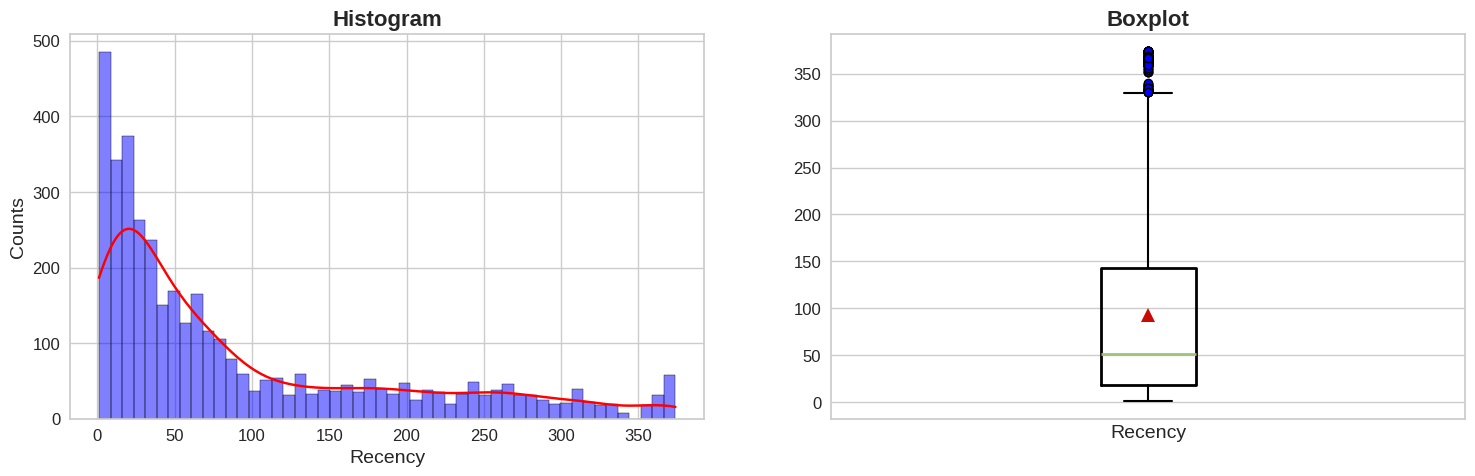

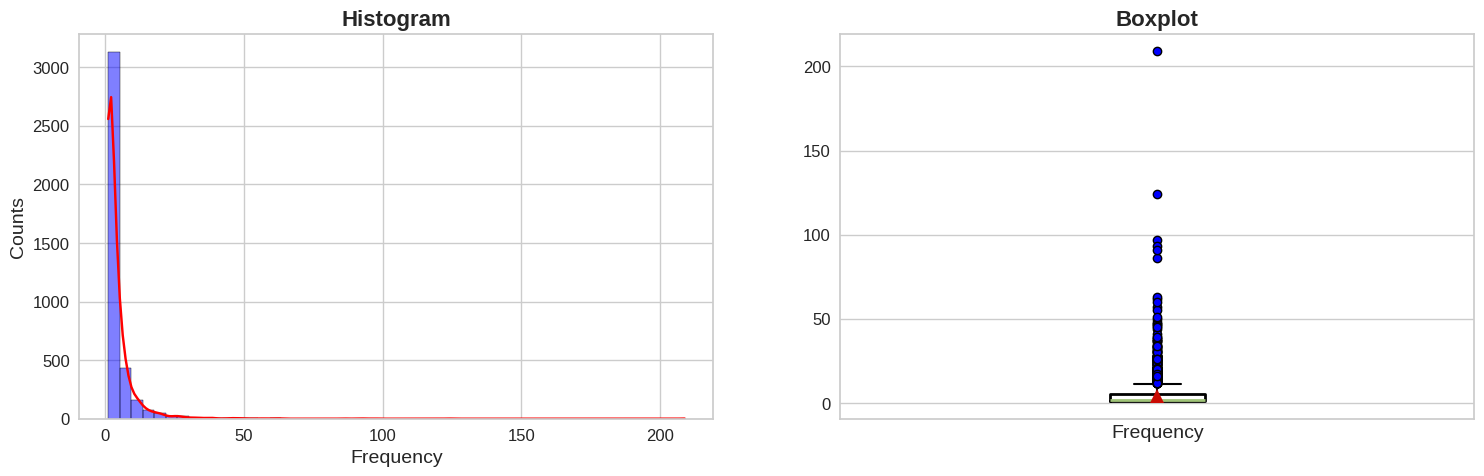

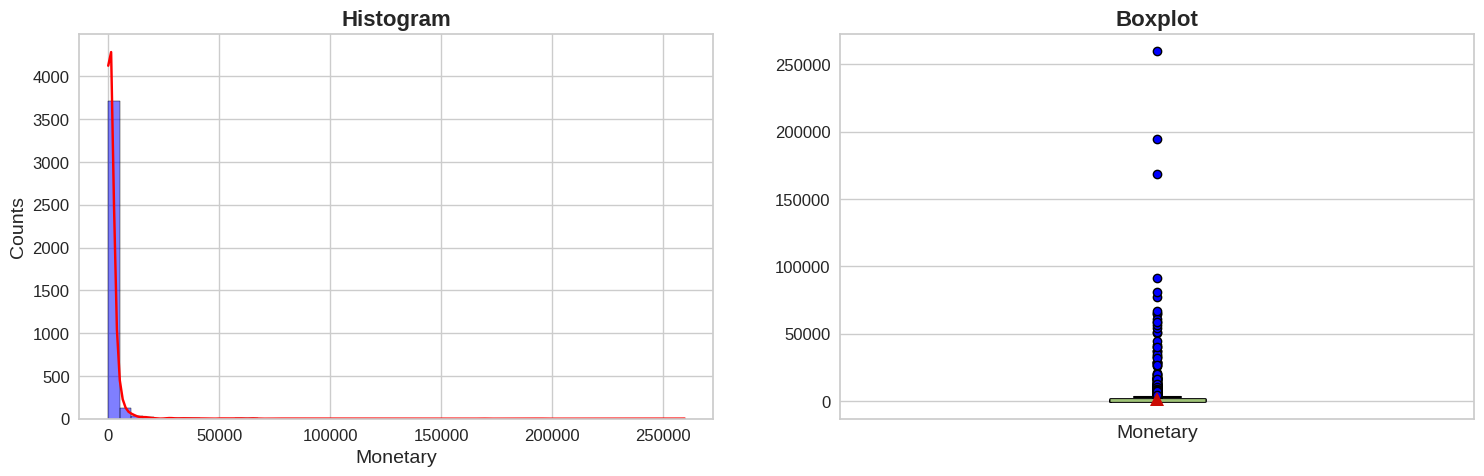

In [118]:
data_vis_before_clean = df5
row_axs, col_axs = 1,2
boxprops = dict(linewidth=2)
whiskerprops= dict(linewidth=1.5)
capprops= dict(linewidth=1.5)
flierprops = dict(marker='o', markerfacecolor='blue')
medianprops = dict(linewidth=2)
meanprops = dict(markersize=10)

features = list(data_vis_before_clean.keys())
for i in range(len(features)):
  fig1, axis1 = plt.subplots(row_axs,col_axs, figsize=(18, 5))
  temp_x = data_vis_before_clean[features[i]]
  sns.histplot(temp_x,bins=50, kde=True,
                color = 'Blue' , legend=False,ax=axis1[0])#hist(temp_x,bins=100)
  axis1[0].lines[0].set_color('red')
  axis1[0].set_title('Histogram', fontsize = 16, weight='bold')
  axis1[0].set_xlabel(features[i],fontsize = 14)
  axis1[0].set_ylabel('Counts',fontsize = 14)
  axis1[0].grid(visible = True)
  axis1[0].tick_params(axis='both', which='major', labelsize=12)
  axis1[1].boxplot(temp_x ,showmeans = True, boxprops = boxprops,
                     whiskerprops = whiskerprops, capprops= capprops,
                     flierprops = flierprops,medianprops = medianprops,
                     meanprops = meanprops)
  axis1[1].set_title('Boxplot', fontsize = 16, weight='bold')
  axis1[1].set_xlabel(features[i],fontsize = 14)
  axis1[1].set_ylabel('',fontsize = 14)
  axis1[1].tick_params(axis='both', which='major', labelsize=12)
  axis1[1].set_xticks([])
  axis1[1].grid(visible = True)
  plt.show()

##**CLEAN DATA**

**Outliers function**

In [119]:
def cap_outliers_IQR(df_col):
  q1=df_col.quantile(0.25)

  q3=df_col.quantile(0.75)

  IQR=q3-q1

  upper_limit = df_col.mean() + 3*df_col.std()

  lower_limit = df_col.mean() - 3*df_col.std()

  df_col = np.where(df_col > upper_limit,
    upper_limit,
    np.where(
        df_col < lower_limit,
        lower_limit,
        df_col
    )
  )
  return df_col

def impute_outliers_IQR(df_col):

   q1=df_col.quantile(0.25)

   q3=df_col.quantile(0.75)

   IQR=q3-q1

   upper = df_col[df_col<=(q3+1.5*IQR)].max()

   lower = df_col[df_col>=(q1-1.5*IQR)].min()

   df_col = np.where(df_col > upper,

       df_col.mean(),

       np.where(

           df_col < lower,

           df_col.mean(),

           df_col

           )

       )

   return df_col

def outliers(df,feature):
  q1 = df[feature].quantile(0.25)
  q3=df[feature].quantile(0.75)

  IQR=q3-q1

  lower_bound = q1 - 1.5*IQR
  upper_bound = q3 + 1.5*IQR

  idx_outliers = df[((df[feature] < lower_bound) | (df[feature] > upper_bound))].index.tolist()
  return idx_outliers

def remove_out_2(df):
  p_r,p_c = df.shape
  idx_list = 'first'
  it =0
  while len(idx_list)!= 0 and it <10:
    it += 1
    idx_list = []
    for ft in df.columns:
      idx_list.extend(outliers(df,ft))
    if len(idx_list) == 0:
      break
    idx_list = sorted(set(idx_list))
    df = df.drop(idx_list, axis=0)
    p2_r,p2_c = df.shape
  print('REMOVE OUTLIERS:\n')
  print('Number of loops =', it)
  print('Number of samples - before remove outliers =',p_r)
  print('Number of samples - after remove outliers =',p2_r)
  print('Function remove',p_r - p2_r,'samples')
  return df

**Right-skewed function**

In [107]:
def np_log_skewness(df,limit, func):
  # check the skew value of each feature
  skew_vals = df.skew()
  skew_cols = skew_vals[abs(skew_vals)> limit].sort_values(ascending=False)
  print('Skew of each column:\n',skew_cols)


  df_trains = df.copy()
  if func == 'log':
    rfm_log = df[skew_cols.index].copy() # take skew right or left columns of data
    for col in skew_cols.index.values:
        rfm_log[col] = rfm_log[col].apply(np.log1p)
        df_trains[col] = rfm_log[col]
    print('Skew of each column after applied log transform:\n',
          rfm_log.skew())
  elif func == 'power':
    rfm_before_trans = df[skew_cols.index].copy()
    pt = PowerTransformer(method='yeo-johnson')
    trans= pt.fit_transform(rfm_before_trans)
    rfm_trans = pd.DataFrame(trans, columns =skew_cols.index, index = df_trains.index)
    df_trains[skew_cols.index.values] = rfm_trans
    print('Skew of each column after applied power transform:\n',
          rfm_trans.skew())

  rfm_result = df_trains

  for skew in rfm_result.skew():
      if -0.75 < skew < 0.75:
          print ("A skewness value of", '\033[1m', Fore.GREEN, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.GREEN, "symmetric", '\033[0m')
      elif  -0.75 < skew < -1.0 or 0.75 < skew < 1.0:
          print ("A skewness value of", '\033[1m', Fore.YELLOW, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.YELLOW, "moderately skewed", '\033[0m')
      else:
          print ("A skewness value of", '\033[1m', Fore.RED, skew, '\033[0m', "means that the distribution is approx.", '\033[1m', Fore.RED, "highly skewed", '\033[0m')

  return rfm_result

**Z-normalization function**

In [108]:
def z_normal(df):
  new_df = df.copy()
  features = list(df.keys())
  for i in range(len(features)):
    data = new_df[features[i]]
    # Calculate the mean
    mean = np.mean(data)
    # Calculate the standard deviation
    std_dev = np.std(data)
    # Perform Z-score normalization
    z_scores = (data - mean) / std_dev
    new_df[features[i]] = z_scores
  return new_df

**Clean data**

In [120]:
# Apply function to clean data
df6 = df5.copy()

# Step 1: Right-skewed
df6 = np_log_skewness(df6,0.75,'log')

# Step 2: normalization
df6 = z_normal(df6)

# Step 3: outlier
for i in range(len(features)):
  df6[features[i]] = cap_outliers_IQR(df6[features[i]])
'''
df6 = remove_out_2(df6)
'''

print('Statistic of df5 dataframe')
df6.describe()

Skew of each column:
 Monetary    20.22
Frequency   10.75
Recency      1.24
dtype: float64
Skew of each column after applied log transform:
 Monetary     0.37
Frequency    1.18
Recency     -0.33
dtype: float64
A skewness value of   -0.3261881332841982  means that the distribution is approx.   symmetric 
A skewness value of   1.1822488645974094  means that the distribution is approx.   highly skewed 
A skewness value of   0.37313451126449804  means that the distribution is approx.   symmetric 
Statistic of df5 dataframe


Recency  Frequency  Monetary
count  3920.00    3920.00   3920.00
mean     -0.00      -0.01     -0.00
std       1.00       0.97      0.98
min      -2.42      -0.96     -3.00
25%      -0.70      -0.96     -0.67
50%       0.07      -0.36     -0.06
75%       0.85       0.65      0.66
max       1.59       3.00      3.00

**Visualize**

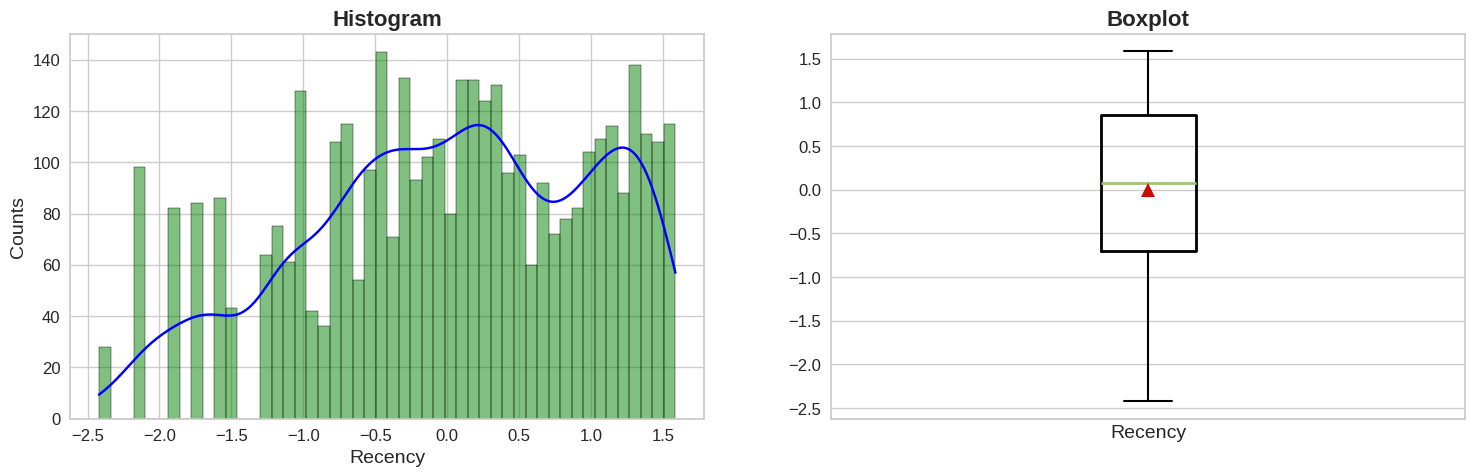

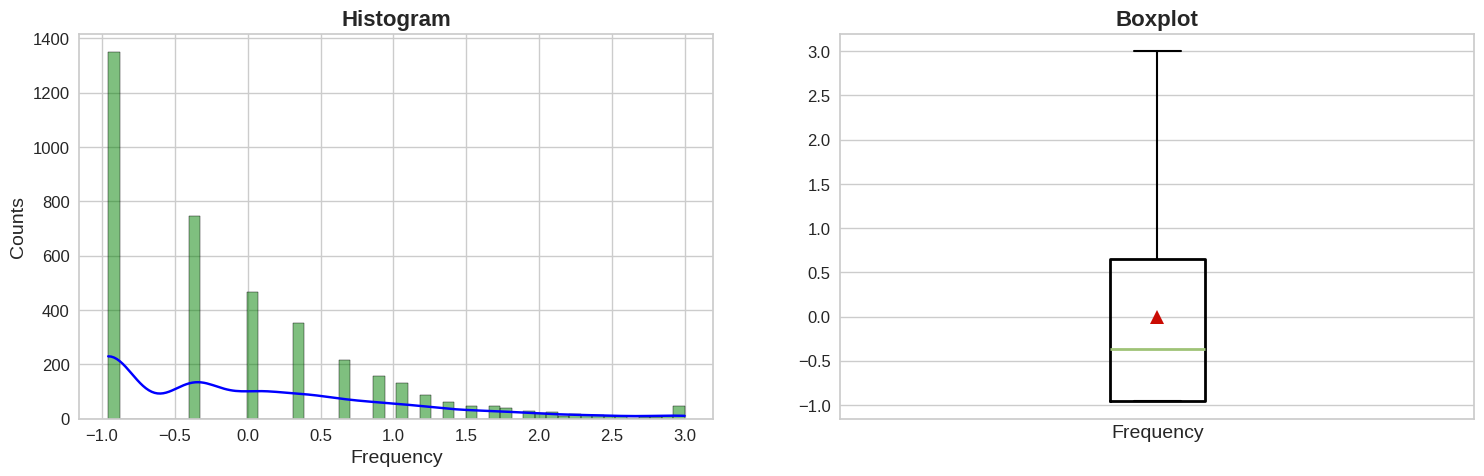

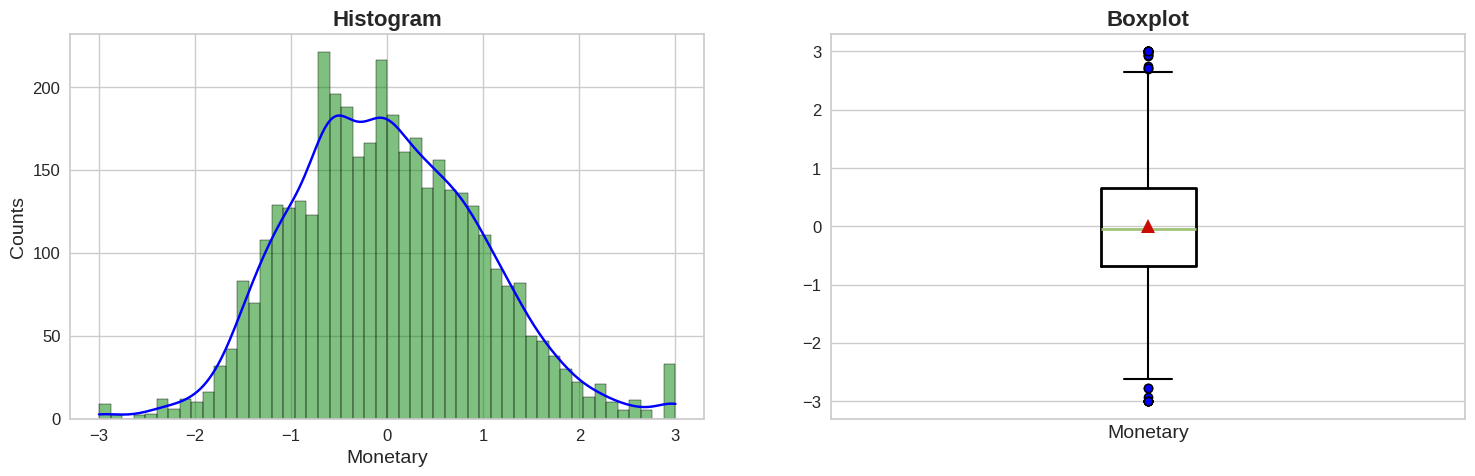

In [121]:
data_vis = df6

row_axs, col_axs = 1,2
boxprops = dict(linewidth=2)
whiskerprops= dict(linewidth=1.5)
capprops= dict(linewidth=1.5)
flierprops = dict(marker='o', markerfacecolor='blue')
medianprops = dict(linewidth=2)
meanprops = dict(markersize=10)

features = list(data_vis.keys())
for i in range(len(features)):
  fig1, axis1 = plt.subplots(row_axs,col_axs, figsize=(18, 5))
  temp_x = data_vis[features[i]]
  sns.histplot(temp_x,bins=50, kde=True,
                color = 'Green' , legend=False,ax=axis1[0])#hist(temp_x,bins=100)
  axis1[0].lines[0].set_color('blue')
  axis1[0].set_title('Histogram', fontsize = 16, weight='bold')
  axis1[0].set_xlabel(features[i],fontsize = 14)
  axis1[0].set_ylabel('Counts',fontsize = 14)
  axis1[0].grid(visible = True)
  axis1[0].tick_params(axis='both', which='major', labelsize=12)
  axis1[1].boxplot(temp_x ,showmeans = True, boxprops = boxprops,
                     whiskerprops = whiskerprops, capprops= capprops,
                     flierprops = flierprops,medianprops = medianprops,
                     meanprops = meanprops)
  axis1[1].set_title('Boxplot', fontsize = 16, weight='bold')
  axis1[1].set_xlabel(features[i],fontsize = 14)
  axis1[1].set_ylabel('',fontsize = 14)
  axis1[1].tick_params(axis='both', which='major', labelsize=12)
  axis1[1].set_xticks([])
  axis1[1].grid(visible = True)
  plt.show()

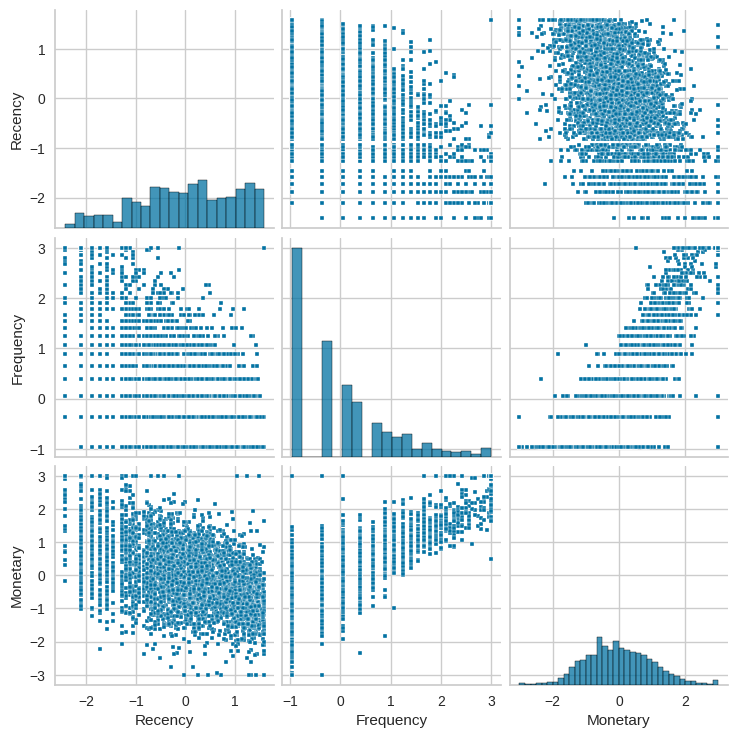

In [122]:
scatter_mat = sns.pairplot(data_vis, markers = 's',plot_kws=dict(s = 10))
display(scatter_mat)

**Correlation**

In [123]:
corr = round(data_vis.corr(),3)
corr_vis = corr.style.background_gradient(cmap = 'Blues')
display(corr_vis)

#**CLUSTERING**

##**K-means clustering**

In [124]:
data = df6
rfm_trains = data

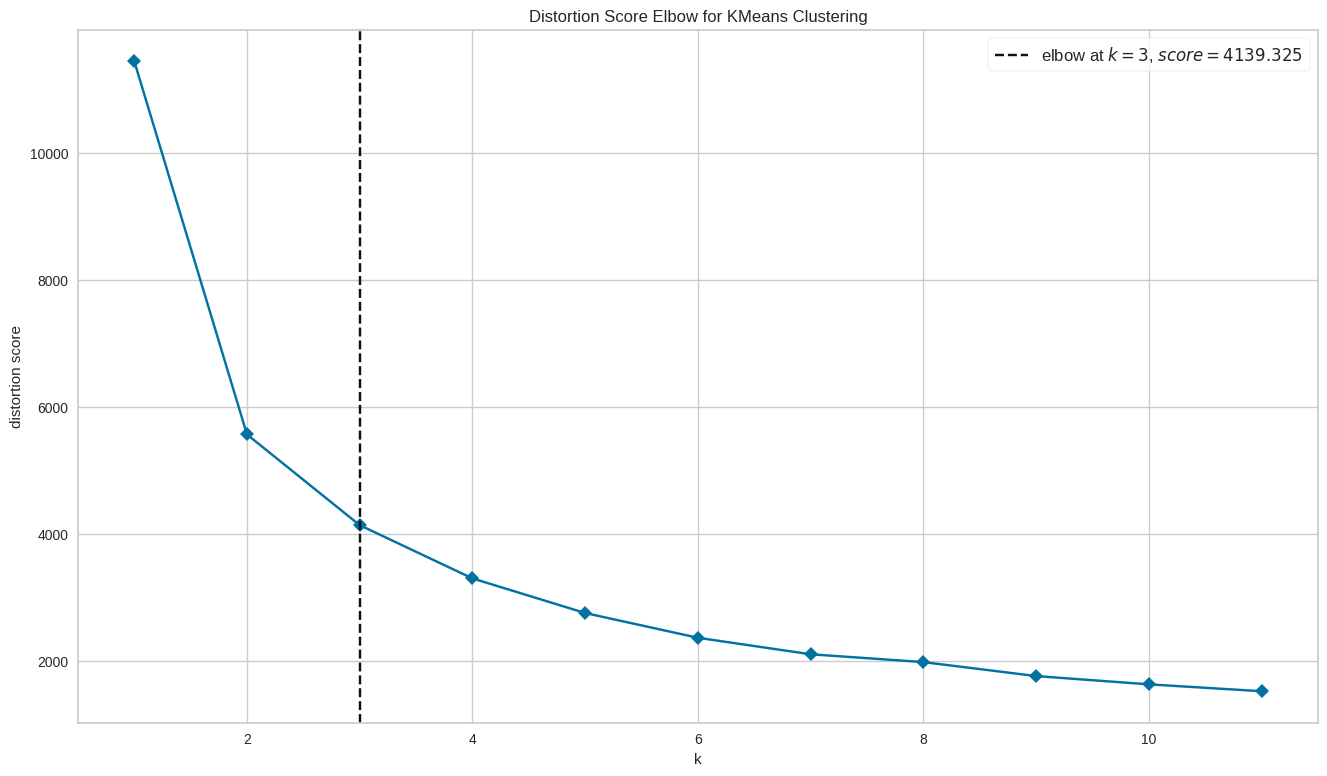

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [125]:
inertias = []
nth_clusters = 11

kmeans_kwargs = {"random_state": 42}

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,nth_clusters+1), timings = False)
visualizer.fit(rfm_trains)        # Fit the data to the visualizer
visualizer.show()

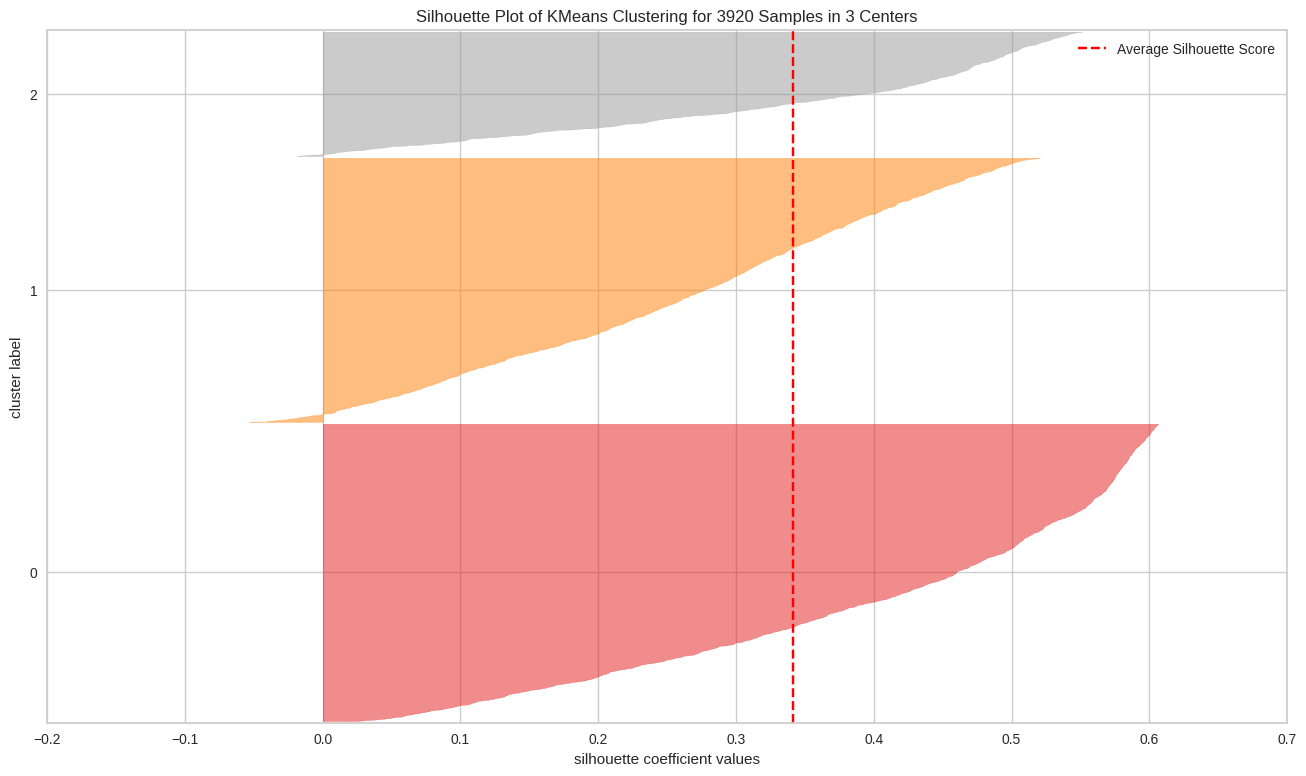

In [126]:
model_3 = KMeans(n_clusters=3, random_state=42)
visualizer = SilhouetteVisualizer(model_3)

visualizer.fit(rfm_trains)    # Fit the data to the visualizer
visualizer.poof();

In [127]:
 # Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=3,**kmeans_kwargs)

# Fit the algorithms to the features
kmeans.fit(rfm_trains)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(rfm_trains, kmeans.labels_).round(3)
print('Silhouette score =',kmeans_silhouette)

Silhouette score = 0.341


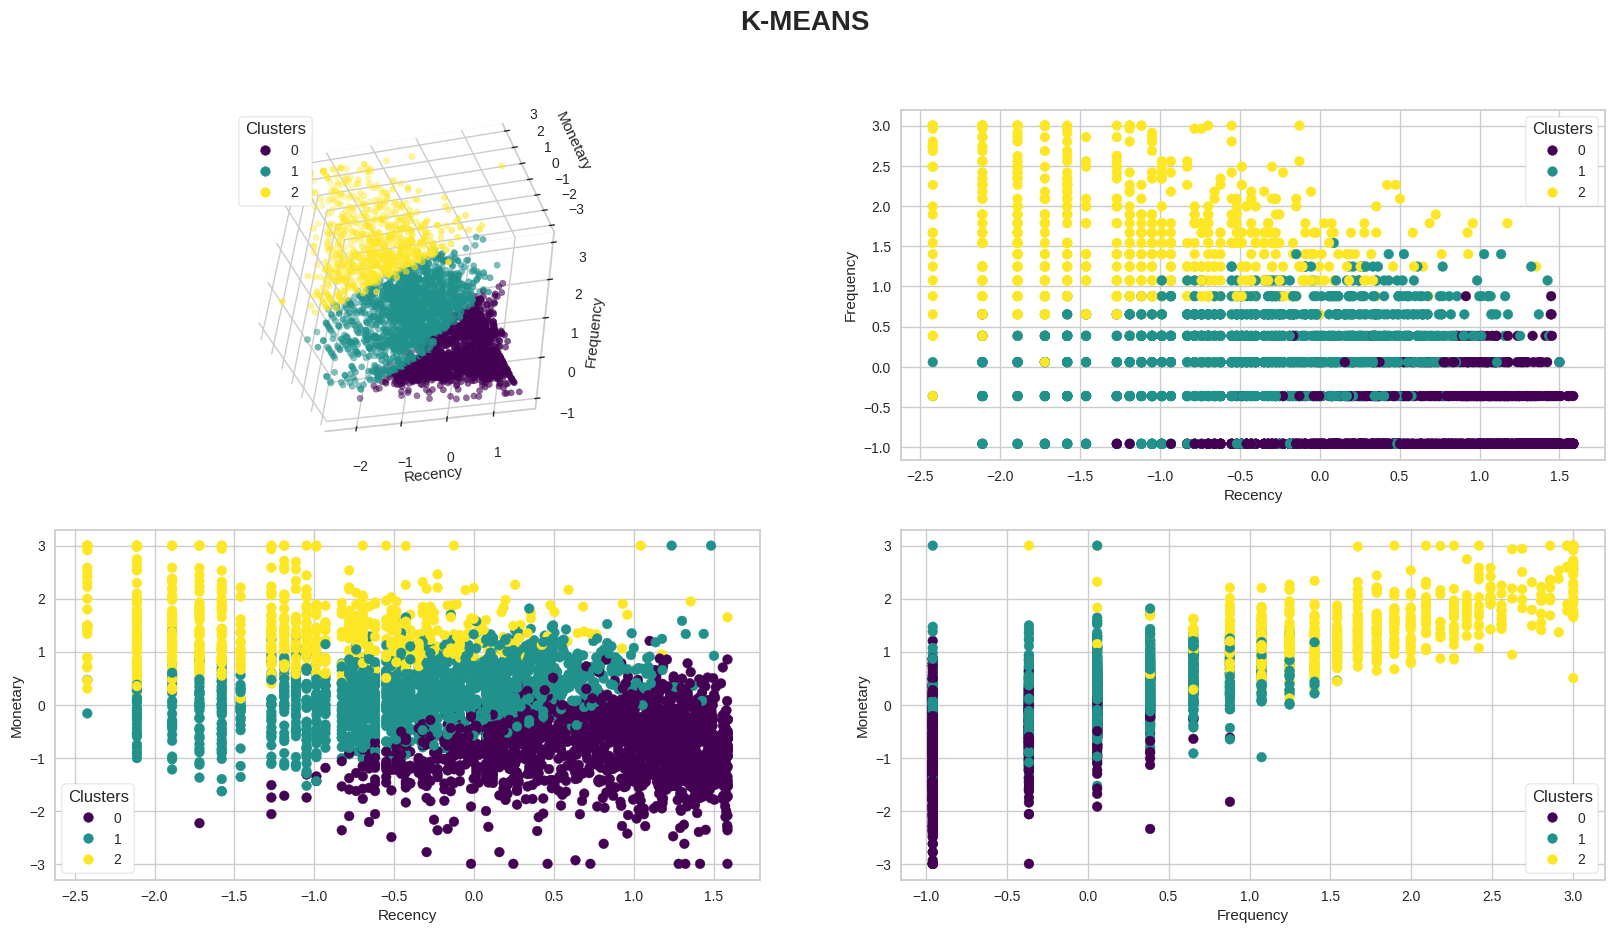

In [128]:
# Create a 2x1 grid of subplots
# set up a figure twice as wide as it is tall
fig3= plt.figure(figsize=(20, 10))
nth_r, nth_c = 2,2
ax30 = fig3.add_subplot(nth_r, nth_c,1, projection='3d')
plt.suptitle("K-MEANS", fontsize=20, weight='bold')


# Plot the explained variance ratio in the first subplot
plot30 = ax30.scatter(rfm_trains['Recency'],rfm_trains['Frequency'],rfm_trains['Monetary'],c=kmeans.labels_, cmap = 'viridis')
ax30.set_xlabel("Recency")
ax30.set_ylabel("Frequency")
ax30.set_zlabel('Monetary')
# produce a legend with the unique colors from the scatter
legend30 = ax30.legend(*plot30.legend_elements(),title="Clusters", loc = 'upper left', frameon=True)
legend30.get_frame().set_facecolor('white')
legend30.get_frame().set_alpha(1)
ax30.add_artist(legend30)
# Rotate the axes
# Cycle through a full rotation of elevation, then azimuth, roll, and all
elev= 45
azim= -60
roll= 30
# Update the axis view and title
ax30.view_init(elev, azim, roll)
#ax40.set_title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))
# Make the plot look cleaner
ax30.xaxis.pane.fill = False
ax30.yaxis.pane.fill = False
ax30.zaxis.pane.fill = False

ax31 = fig3.add_subplot(nth_r, nth_c,2)
plot31 = ax31.scatter(rfm_trains['Recency'],rfm_trains['Frequency'],c=kmeans.labels_, cmap = 'viridis')
ax31.set_xlabel("Recency")
ax31.set_ylabel("Frequency")
# produce a legend with the unique colors from the scatter
legend31 = ax31.legend(*plot31.legend_elements(),title="Clusters", frameon=True)
legend31.get_frame().set_facecolor('white')
legend31.get_frame().set_alpha(1)
ax31.add_artist(legend31)

ax32 = fig3.add_subplot(nth_r, nth_c,3)
plot32 = ax32.scatter(rfm_trains['Recency'],rfm_trains['Monetary'],c=kmeans.labels_, cmap = 'viridis')
ax32.set_xlabel("Recency")
ax32.set_ylabel("Monetary")
# produce a legend with the unique colors from the scatter
legend32 = ax32.legend(*plot32.legend_elements(),title="Clusters", frameon=True)
legend32.get_frame().set_facecolor('white')
legend32.get_frame().set_alpha(1)
ax32.add_artist(legend32)

ax33 = fig3.add_subplot(nth_r, nth_c,4)
plot33 = ax33.scatter(rfm_trains['Frequency'],rfm_trains['Monetary'],c=kmeans.labels_, cmap = 'viridis')
ax33.set_xlabel("Frequency")
ax33.set_ylabel("Monetary")
# produce a legend with the unique colors from the scatter
legend33 = ax33.legend(*plot33.legend_elements(),title="Clusters", frameon=True)
legend33.get_frame().set_facecolor('white')
legend33.get_frame().set_alpha(1)
ax33.add_artist(legend33)

# Display the figure
plt.show()

In [129]:
# Print centroids
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(
    centroids,
    columns=rfm_trains.columns,
    index=[f'Cluster_{i}' for i in range(3)])
display(centroids_df)

Recency  Frequency  Monetary
Cluster_0     0.77      -0.76     -0.77
Cluster_1    -0.34       0.10      0.22
Cluster_2    -1.13       1.59      1.38

##**DBSCAN**

**MinPoints and Epsilon Selection**

minPoints = 2 * dimensional dataset


epsilon: plot each datapoint is away to its k nearest neighbour. k = number of minPoints => use the elbow of the plot => the epsilon value could be overlapping with a different cluster

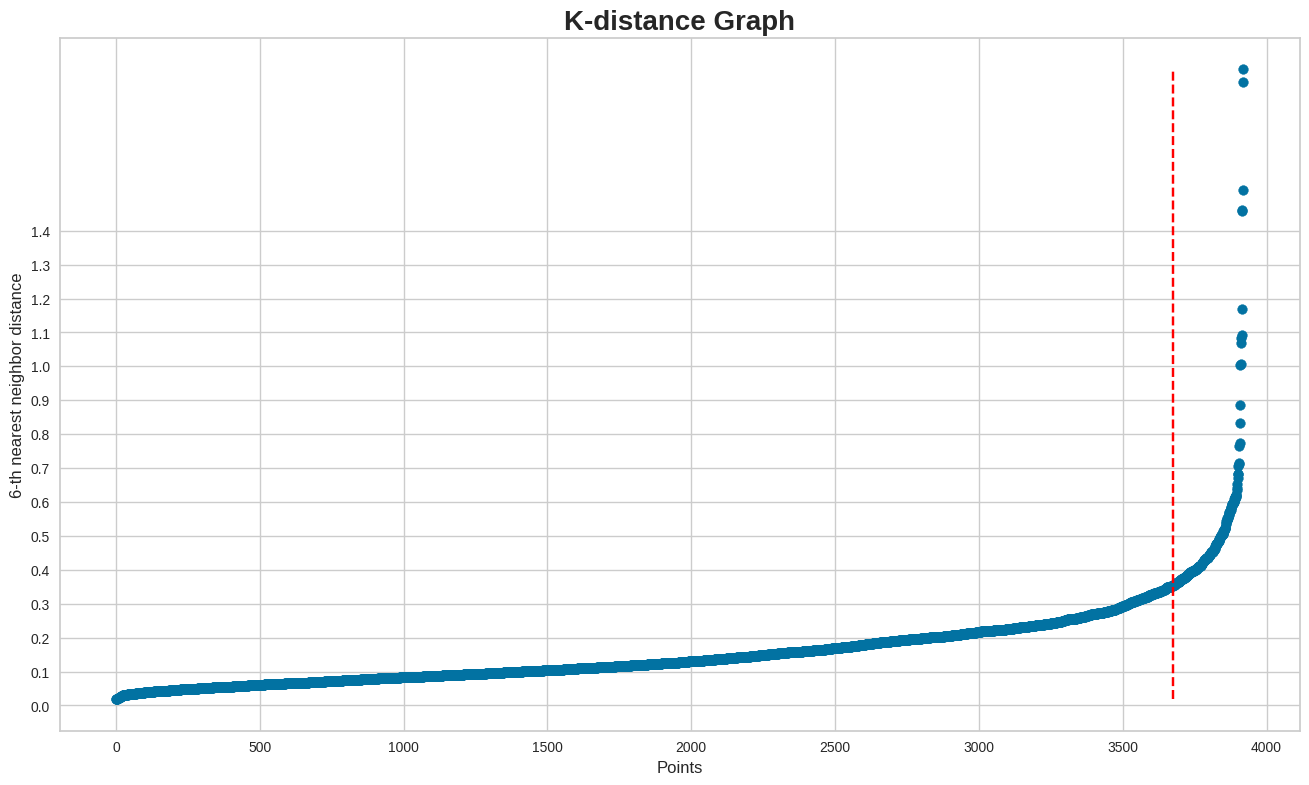

slected minPoints = 6
eps = 0.3542401781510206


In [130]:
minPoints = 6

neigh = NearestNeighbors(n_neighbors=minPoints)
neigh.fit(rfm_trains)
distances, _ = neigh.kneighbors(rfm_trains)
distances = np.sort(distances[:, minPoints-1])

rotor = Rotor()
curve_xy = np.concatenate([np.arange(distances.shape[0]).reshape(-1,1),distances.reshape(-1,1)],1)
rotor.fit_rotate(curve_xy)
e_idx = rotor.get_elbow_index()
rotor.plot_elbow()
idx, eps_value = curve_xy[e_idx]

# plot distances
plt.xlabel('Points',  fontsize = 12)
plt.ylabel(f'{minPoints}-th nearest neighbor distance', fontsize = 12)
plt.title('K-distance Graph', fontsize = 20, weight = 'bold')
#plt.xlim(3500,4000)
plt.gca().set_yticks(np.arange(0, 1.5, 0.1))  # Vạch chia nhỏ
plt.show()

print('slected minPoints =',minPoints)

plt.show()
print('eps =',eps_value)


In [131]:
 # Instantiate k-means and dbscan algorithms
dbscan = DBSCAN(eps=eps_value,min_samples=minPoints)

# Fit the algorithms to the features
dbscan.fit(rfm_trains)

# Compute the silhouette scores
dbscan_silhouette = silhouette_score(rfm_trains, dbscan.labels_).round (3)
print('Silhouette score =',dbscan_silhouette)

Silhouette score = 0.146


In [132]:
print('Number of clusters =',len(np.unique(dbscan.labels_)))
print('detect label, -1 based on noise data:', np.unique(dbscan.labels_))

Number of clusters = 4
detect label, -1 based on noise data: [-1  0  1  2]


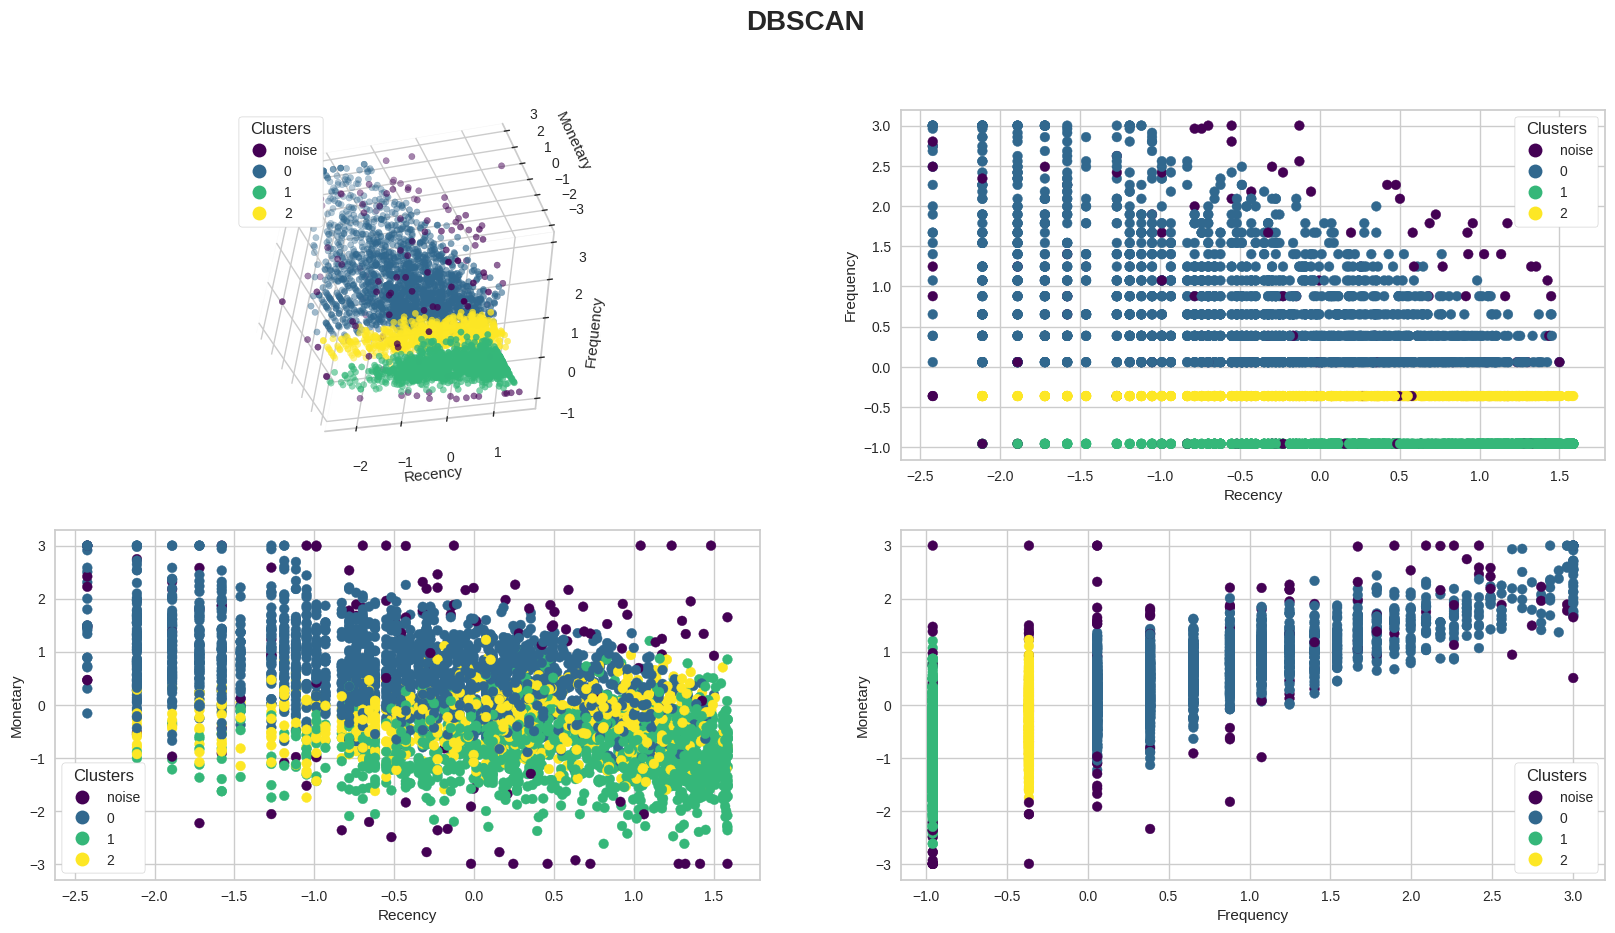

In [133]:
fig4= plt.figure(figsize=(20, 10))
nth_r, nth_c = 2,2
ax40 = fig4.add_subplot(nth_r, nth_c,1, projection='3d')
plt.suptitle("DBSCAN", fontsize=20, weight = 'bold')
all_clus = np.unique(dbscan.labels_)
change_labels = {-1: 'noise',
                 0: 0,
                 1: 1,
                 2: 2}

# Plot the explained variance ratio in the first subplot
plot40 = ax40.scatter(rfm_trains['Recency'],rfm_trains['Frequency'],rfm_trains['Monetary'],c=dbscan.labels_, cmap = 'viridis')
ax40.set_xlabel("Recency")
ax40.set_ylabel("Frequency")
ax40.set_zlabel('Monetary')
# produce a legend with the unique colors from the scatter
# Create elements using for loop
legend_elements40 = []
for i in list(change_labels.keys()):
    element = plt.Line2D([0], [0],
                        marker='o',
                        color='w',
                        markersize=10,
                        markerfacecolor=plot40.cmap(plot40.norm(i)),
                        label=change_labels[i])
    legend_elements40.append(element)
legend40 = ax40.legend(handles=legend_elements40,title="Clusters", loc ='upper left', frameon=True)

legend40.get_frame().set_facecolor('white')
legend40.get_frame().set_alpha(1)
ax40.add_artist(legend40)
# Rotate the axes
# Cycle through a full rotation of elevation, then azimuth, roll, and all
elev= 45
azim= -60
roll= 30
# Update the axis view and title
ax40.view_init(elev, azim, roll)
#ax40.set_title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))
# Make the plot look cleaner
ax40.xaxis.pane.fill = False
ax40.yaxis.pane.fill = False
ax40.zaxis.pane.fill = False

ax41 = fig4.add_subplot(nth_r, nth_c,2)
plot41 = ax41.scatter(rfm_trains['Recency'],rfm_trains['Frequency'],c=dbscan.labels_, cmap = 'viridis')
ax41.set_xlabel("Recency")
ax41.set_ylabel("Frequency")
legend_elements41 = []
for i in list(change_labels.keys()):
    element = plt.Line2D([0], [0],
                        marker='o',
                        color='w',
                        markersize=10,
                        markerfacecolor=plot41.cmap(plot41.norm(i)),
                        label=change_labels[i])
    legend_elements41.append(element)
legend41 = ax41.legend(handles=legend_elements41,title="Clusters", frameon=True)
legend41.get_frame().set_facecolor('white')
legend41.get_frame().set_alpha(1)
ax41.add_artist(legend41)

ax42 = fig4.add_subplot(nth_r, nth_c,3)
plot42 = ax42.scatter(rfm_trains['Recency'],rfm_trains['Monetary'],c=dbscan.labels_, cmap = 'viridis')
ax42.set_xlabel("Recency")
ax42.set_ylabel("Monetary")
legend_elements42 = []
for i in list(change_labels.keys()):
    element = plt.Line2D([0], [0],
                        marker='o',
                        color='w',
                        markersize=10,
                        markerfacecolor=plot42.cmap(plot42.norm(i)),
                        label=change_labels[i])
    legend_elements42.append(element)
legend42 = ax42.legend(handles=legend_elements42,title="Clusters", frameon=True)
legend42.get_frame().set_facecolor('white')
legend42.get_frame().set_alpha(1)
ax42.add_artist(legend42)

ax43 = fig4.add_subplot(nth_r, nth_c,4)
plot43 = ax43.scatter(rfm_trains['Frequency'],rfm_trains['Monetary'],c=dbscan.labels_, cmap = 'viridis')
ax43.set_xlabel("Frequency")
ax43.set_ylabel("Monetary")
legend_elements43 = []
for i in list(change_labels.keys()):
    element = plt.Line2D([0], [0],
                        marker='o',
                        color='w',
                        markersize=10,
                        markerfacecolor=plot43.cmap(plot43.norm(i)),
                        label=change_labels[i])
    legend_elements43.append(element)
legend43 = ax43.legend(handles=legend_elements43,title="Clusters", frameon=True)
legend43.get_frame().set_facecolor('white')
legend43.get_frame().set_alpha(1)
ax43.add_artist(legend43)